# Downloading and preparing stock data

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import yfinance as yf
import datetime
import scipy.stats as stats

from numpy.random import seed
from numpy.random import normal

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

start_date = '2010-01-01'
end_date = '2020-01-01'
ticker = 'INVE-B.ST'
df = yf.download(ticker,start_date,end_date)
df.index = df.index.date
df.index.name = "Date"

df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,33.375000,33.875000,33.375000,33.825001,23.078611,6739900
2010-01-05,33.875000,34.099998,33.775002,34.000000,23.198021,2981928
2010-01-07,33.724998,34.224998,33.674999,33.900002,23.129787,6745776
2010-01-08,34.049999,34.099998,33.750000,33.950001,23.163904,5780292
2010-01-11,34.125000,34.250000,33.900002,33.950001,23.163904,5140340


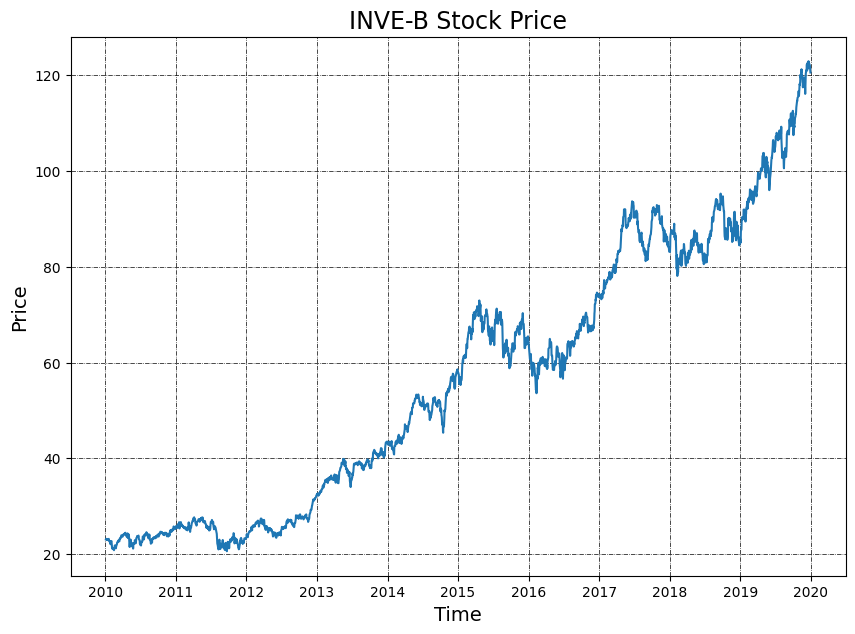

In [64]:
# Stock price plot

df['Adj Close'].plot(figsize=(10,7))
plt.title("INVE-B Stock Price",fontsize=17)
plt.xlabel("Time",fontsize=14)
plt.ylabel("Price",fontsize=14)
plt.grid(which="major", color='k',linestyle='-.',linewidth=0.5)

In [65]:
# check for missing values
df.isna().any()

Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

In [114]:
# creating explanatory variables, 3 day and 9 day moving averages

df['S_3'] = df['Adj Close'].shift(1).rolling(window=3).mean()
df['S_9'] = df['Adj Close'].shift(1).rolling(window=9).mean()
df = df.dropna()
X = df[['S_3','S_9']]
X.head()

,S_3,S_9
Date,,
2010-01-18,22.999018,23.074827
2010-01-19,23.016074,23.069141
2010-01-20,23.055874,23.069141
2010-01-21,23.038818,23.042608
2010-01-22,22.993333,23.012284


# Random Forest Model

$$ \Large MSE=\frac{1}{N}\sum^{N}_{i=1}(f_i-y_i)^2

In [69]:
data = df[['Adj Close']]
data = data.rename(columns = {'Adj Close':'Actual Close'})
data["Target"] = df.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Adj Close"]
prev_price = df.copy()
prev_price = df.shift(1)

predictors = ["Close","Volume", "Open", "High", "Low","Adj Close"]
data = data.join(prev_price[predictors]).iloc[1:]
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

#train = data.iloc[:-100]
#test = data.iloc[-100:]

#model.fit(train[predictors], train["Target"])
#preds = model.predict(test[predictors])
#preds = pd.Series(preds, index=test.index)
#precision_score(test["Target"], preds)
#combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

In [70]:
def backtest(data, model, predictors, start=1000, step=750):

    predictions = []

    for i in range(start, data.shape[0], step):
    
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        model.fit(train[predictors], train["Target"])

        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds <= .6] = 0

        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

        predictions.append(combined)

    return pd.concat(predictions)

In [71]:
predictions = backtest(data, model, predictors)

In [72]:
predictions["Predictions"].value_counts()


0.0    1510
Name: Predictions, dtype: int64

In [73]:
precision_score(predictions["Target"], predictions["Predictions"])

c:\Users\Henke\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

### Plots

<AxesSubplot: xlabel='Date'>

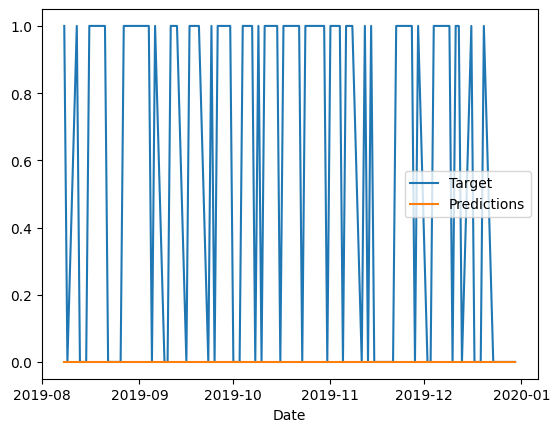

In [74]:
predictions.iloc[-100:].plot()